In [1]:
import json
import pandas as pd
import numpy as np
import missingno as msno
from sklearn.impute import SimpleImputer

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

We will be using the Significant Earthquake Database from NOAA, available as a public dataset on Google BigQuery (table: `bigquery-public-data.noaa_significant_earthquakes.earthquakes`). The metadata for this dataset is available [here](https://console.cloud.google.com/bigquery?project=packt-data&folder&organizationId&p=bigquery-public-data&d=noaa_significant_earthquakes&t=earthquakes&page=table).

Let's take a problem statement of predicting whether a given earthquake produced a tsunami or not. Then, the target variable here would be `flag_tsunami`.

# Read the data and find summary statistics

In [2]:
with open('dtypes.json', 'r') as jsonfile:
    dtyp = json.load(jsonfile)

In [3]:
data = pd.read_csv('earthquake_data.csv', dtype=dtyp)
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,6072.0,4658.426219,2924.650010,1.000,2142.75000,4608.5,6475.25000,10378.000
year,6072.0,1802.307477,377.924931,-2150.000,1818.00000,1927.0,1986.00000,2018.000
month,5667.0,6.510852,3.450167,1.000,4.00000,7.0,9.00000,12.000
day,5515.0,15.734361,8.752862,1.000,8.00000,16.0,23.00000,31.000
hour,4044.0,11.308605,7.033485,0.000,5.00000,11.0,17.00000,23.000
minute,3838.0,28.855915,17.151545,0.000,14.00000,30.0,44.00000,59.000
second,2721.0,29.740243,17.132196,0.100,14.80000,29.7,44.50000,59.900
focal_depth,3120.0,41.680769,71.258782,0.000,11.00000,26.0,40.00000,675.000
eq_primary,4286.0,6.471419,1.043968,1.600,5.70000,6.5,7.30000,9.500
eq_mag_mw,1216.0,6.526562,0.937869,3.600,5.80000,6.5,7.20000,9.500


# Missing Values

## Visualising and analysing missing values

In [4]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()*100/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1,join='outer',
                         keys=['count_missing', 'perc_missing'])

missing_data

,count_missing,perc_missing
state,5764,94.927536
total_damage_millions_dollars,5654,93.115942
damage_millions_dollars,5594,92.127800
injuries,4903,80.747694
total_injuries,4888,80.500659
eq_mag_mw,4856,79.973650
injuries_description,4723,77.783267
total_injuries_description,4715,77.651515
eq_mag_mb,4286,70.586298
deaths,4068,66.996047


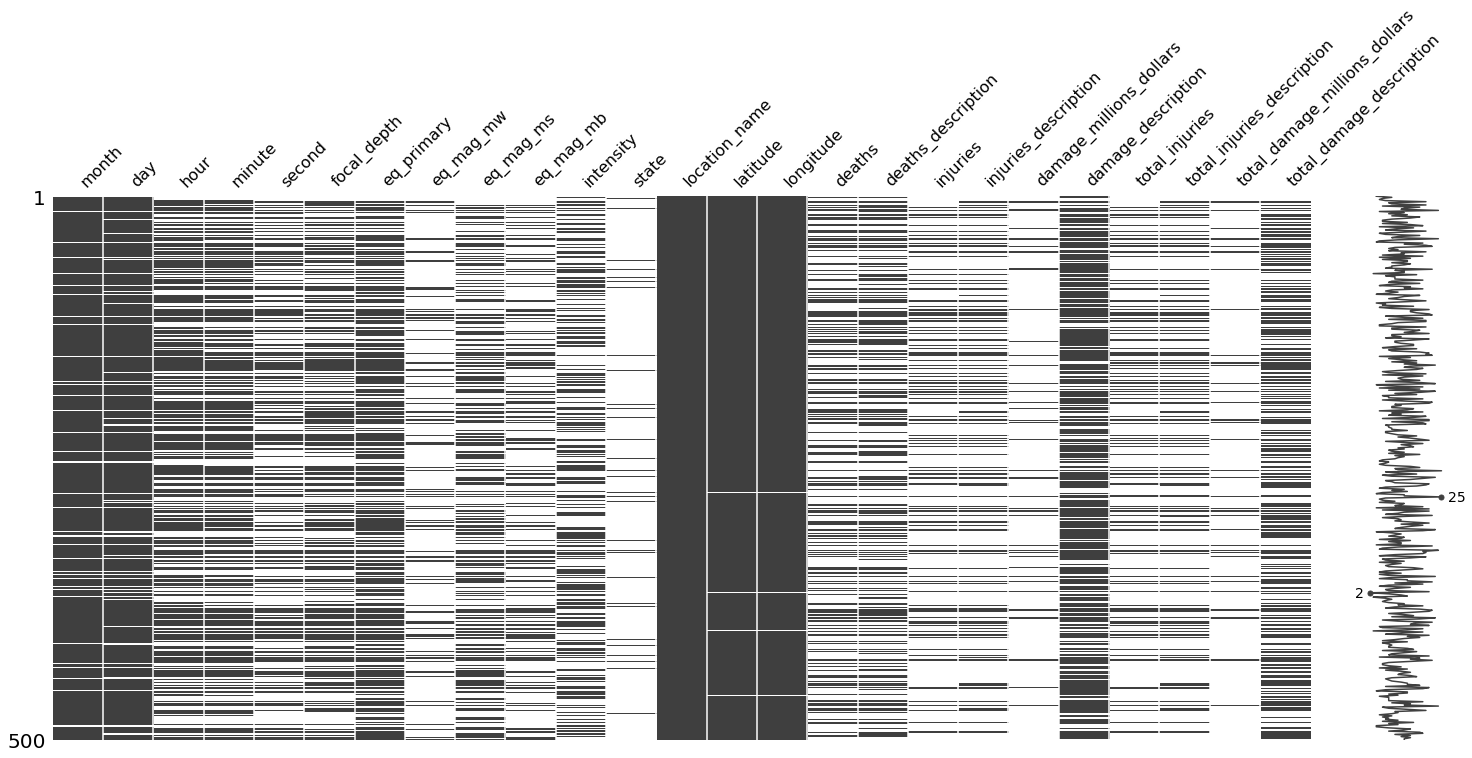

In [5]:
nullable_columns = data.columns[data.isnull().any()].tolist()
msno.matrix(data[nullable_columns].sample(500))
plt.show()

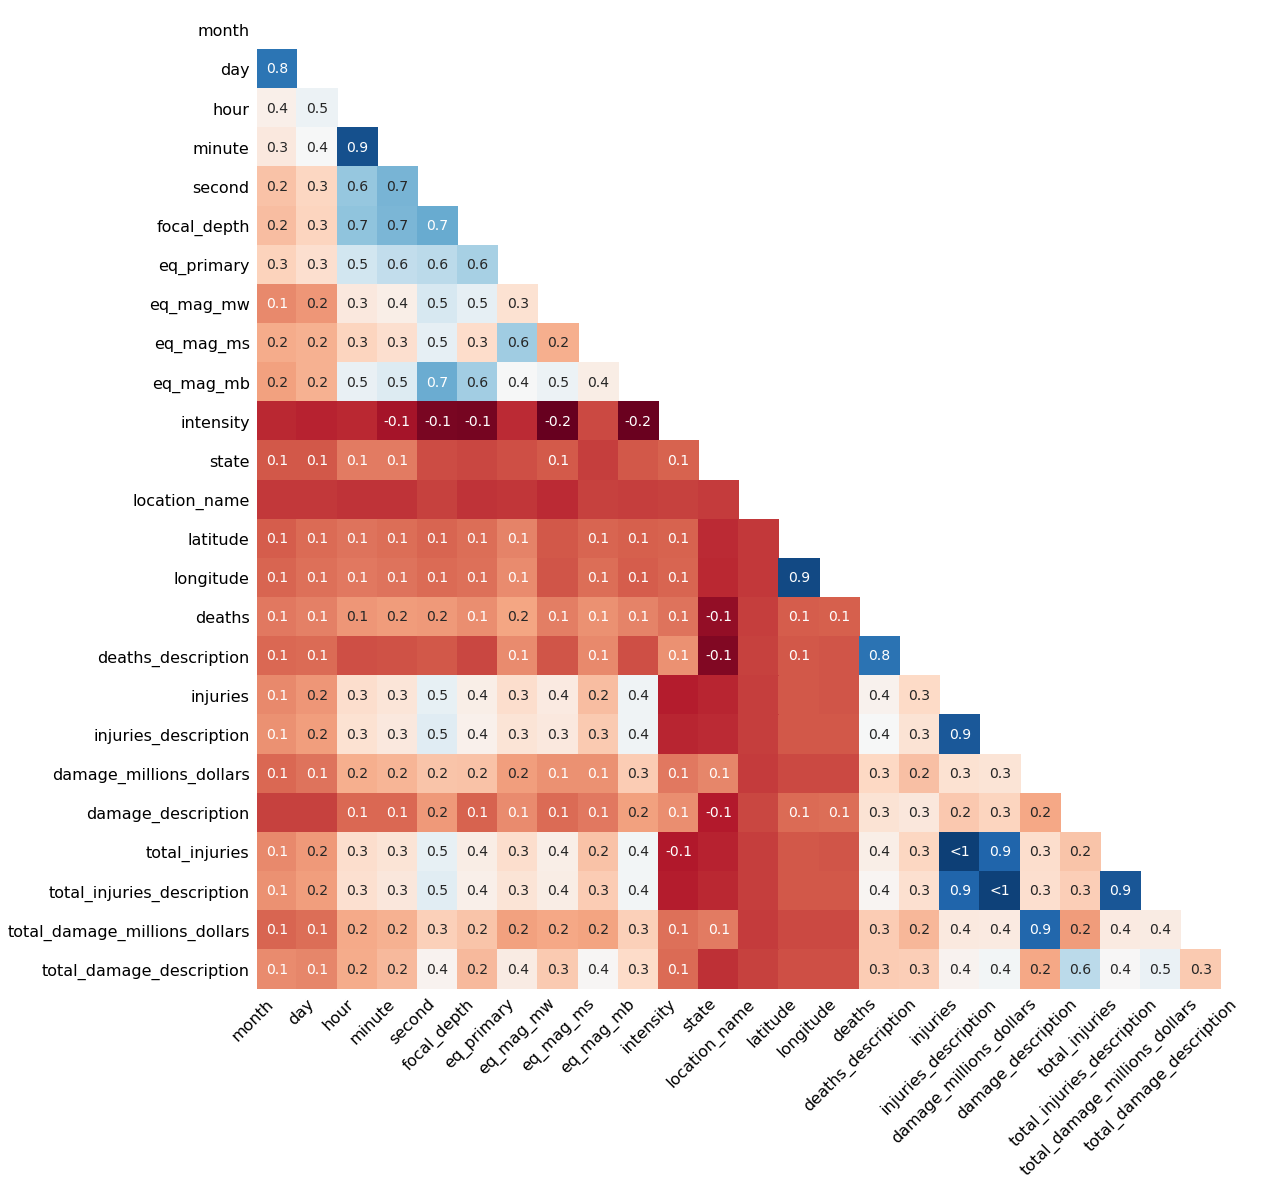

In [6]:
msno.heatmap(data[nullable_columns], figsize=(18,18))
plt.show()

## Dealing with Missing Values

In [7]:
time_features = ['month', 'day', 'hour', 'minute', 'second']

data[time_features] = data[time_features].fillna(0)

In [8]:
data[time_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6072 entries, 0 to 6071
Data columns (total 5 columns):
month     6072 non-null float64
day       6072 non-null float64
hour      6072 non-null float64
minute    6072 non-null float64
second    6072 non-null float64
dtypes: float64(5)
memory usage: 237.3 KB


In [9]:
description_features = [
    'deaths_description', 'injuries_description', 'damage_description',
    'total_injuries_description', 'total_damage_description'
]

imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='NA')
data[description_features] = imp.fit_transform(data[description_features])

In [10]:
data[description_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6072 entries, 0 to 6071
Data columns (total 5 columns):
deaths_description            6072 non-null object
injuries_description          6072 non-null object
damage_description            6072 non-null object
total_injuries_description    6072 non-null object
total_damage_description      6072 non-null object
dtypes: object(5)
memory usage: 237.3+ KB


In [11]:
data[pd.isnull(data.damage_millions_dollars)].shape[0]

5594

In [12]:
data[pd.isnull(data.damage_millions_dollars) & (data.damage_description != 'NA')].shape[0]

3849

We know that all variables having column names ending with `_description` are a descriptor field containing estimates for data that may not be available in the original numerical column. For the `deaths`, `injuries` and `total_injuries`, the corresponding categorical values represent: 

- 0 = None
- 1 = Few (~1 to 50 deaths)
- 2 = Some (~51 to 100 deaths)
- 3 = Many (~101 to 1000 deaths)
- 4 = Very Many (~1001 or more deaths)

For the `damage_millions_dollars`, the corresponding categorical values represent:

- 0 = None
- 1 = Limited (roughly corresponding to less than 1 million dollars)
- 2 = Moderate (~1 to 5 million dollars)
- 3 = Severe (~>5 to 24 million dollars)
- 4 = Extreme (~25 million dollars or more)


In [13]:
data[['damage_description', 'damage_millions_dollars']].groupby('damage_description').mean()

,damage_millions_dollars
damage_description,
1,0.417211
2,3.078840
3,13.818806
4,3574.998799
NA,NaN


In [14]:
replacement_values = data[['damage_description', 'damage_millions_dollars']]\
                         .groupby('damage_description').mean()\
                         .damage_millions_dollars.to_dict()
replacement_values['NA'] = -1
replacement_values[0] = 0
replacement_values

{'1': 0.4172105263157895,
 '2': 3.0788402777777772,
 '3': 13.818805970149256,
 '4': 3574.9987991266385,
 'NA': -1,
 0: 0}

In [15]:
data['damage_millions_dollars'] = np.where(data.damage_millions_dollars.isnull(),
                                           data.damage_description.map(replacement_values),
                                           data.damage_millions_dollars)

In [16]:
data[['damage_millions_dollars']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6072 entries, 0 to 6071
Data columns (total 1 columns):
damage_millions_dollars    6072 non-null float64
dtypes: float64(1)
memory usage: 47.5 KB


# Distribution of values

## Target variable

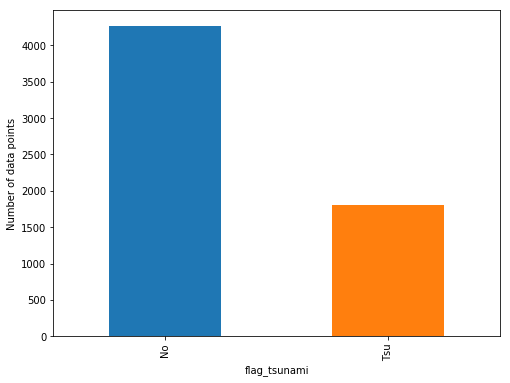

In [17]:
plt.figure(figsize=(8,6))
data.flag_tsunami.value_counts().plot(kind='bar')
plt.ylabel('Number of data points')
plt.xlabel('flag_tsunami')
plt.show()

## Categorical data

In [18]:
numeric_variables = data.select_dtypes(include=[np.number])
numeric_variables.columns

Index(['id', 'year', 'month', 'day', 'hour', 'minute', 'second', 'focal_depth',
       'eq_primary', 'eq_mag_mw', 'eq_mag_ms', 'eq_mag_mb', 'intensity',
       'latitude', 'longitude', 'deaths', 'injuries',
       'damage_millions_dollars', 'total_injuries',
       'total_damage_millions_dollars'],
      dtype='object')

In [19]:
object_variables = data.select_dtypes(include=[np.object])
object_variables.columns

Index(['flag_tsunami', 'country', 'state', 'location_name', 'region_code',
       'deaths_description', 'injuries_description', 'damage_description',
       'total_injuries_description', 'total_damage_description'],
      dtype='object')

In [20]:
numeric_variables.nunique().sort_values()

intensity                          11
month                              13
hour                               24
day                                32
eq_mag_mb                          47
eq_mag_mw                          54
eq_mag_ms                          55
minute                             60
eq_primary                         64
focal_depth                       197
total_damage_millions_dollars     233
damage_millions_dollars           248
injuries                          338
total_injuries                    344
deaths                            416
second                            576
year                              946
latitude                         2885
longitude                        3654
id                               6072
dtype: int64

In [21]:
object_variables.nunique().sort_values()

flag_tsunami                     2
injuries_description             5
damage_description               5
total_injuries_description       5
total_damage_description         5
deaths_description               6
region_code                     18
state                           29
country                        155
location_name                 3821
dtype: int64

In [22]:
data.deaths_description.value_counts(dropna=False)

NA    3599
1     1249
3      597
4      366
2      259
0        2
Name: deaths_description, dtype: int64

In [23]:
data.deaths_description.value_counts(dropna=False).reset_index().sort_values(by='index')

,index,deaths_description
5,0,2
1,1,1249
4,2,259
2,3,597
3,4,366
0,NA,3599


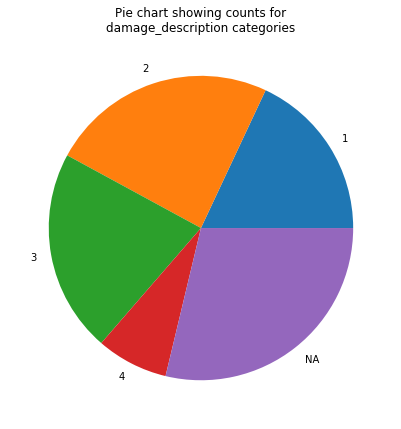

In [24]:
counts = data.damage_description.value_counts()
counts = counts.sort_index()

plt.figure(figsize=(10,7))
plt.pie(counts, labels=counts.index)
plt.title('Pie chart showing counts for\ndamage_description categories')
plt.show()

## Continuous variables

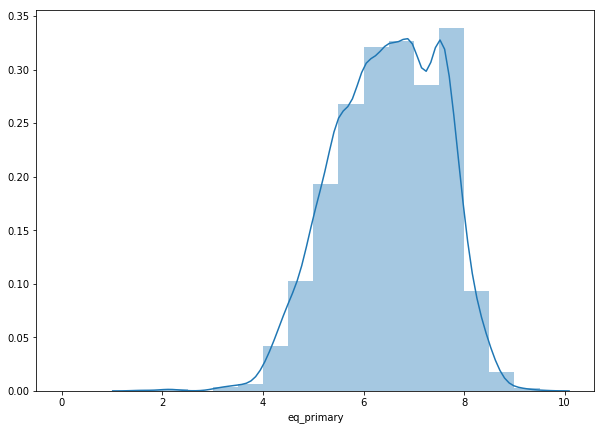

In [25]:
plt.figure(figsize=(10,7))
sns.distplot(data.eq_primary.dropna(), bins=np.linspace(0,10,21))
plt.show()

In [26]:
data.skew().sort_values()

year                             -3.859655
latitude                         -1.038393
region_code                      -0.539048
longitude                        -0.457442
intensity                        -0.442065
eq_primary                       -0.295823
eq_mag_ms                        -0.243581
eq_mag_mb                        -0.058037
month                            -0.012936
day                               0.036121
eq_mag_mw                         0.154842
id                                0.300563
hour                              0.570365
minute                            0.618738
second                            1.096737
focal_depth                       5.866408
total_damage_millions_dollars    13.227907
deaths                           20.020533
total_injuries                   22.191856
injuries                         24.428284
damage_millions_dollars          47.532464
dtype: float64

In [27]:
data.kurt()

id                                 -0.866617
year                               19.532730
month                              -1.202962
day                                -1.228782
hour                               -1.132145
minute                             -1.050225
second                             -0.272400
focal_depth                        40.911649
eq_primary                         -0.327067
eq_mag_mw                          -0.593857
eq_mag_ms                          -0.486214
eq_mag_mb                           0.432798
intensity                           0.072622
latitude                            0.384692
longitude                          -0.777352
region_code                        -1.324200
deaths                            560.274768
injuries                          672.946635
damage_millions_dollars          2725.970362
total_injuries                    569.624067
total_damage_millions_dollars     202.895621
dtype: float64

# Relationships within the data

## Between continuous variables

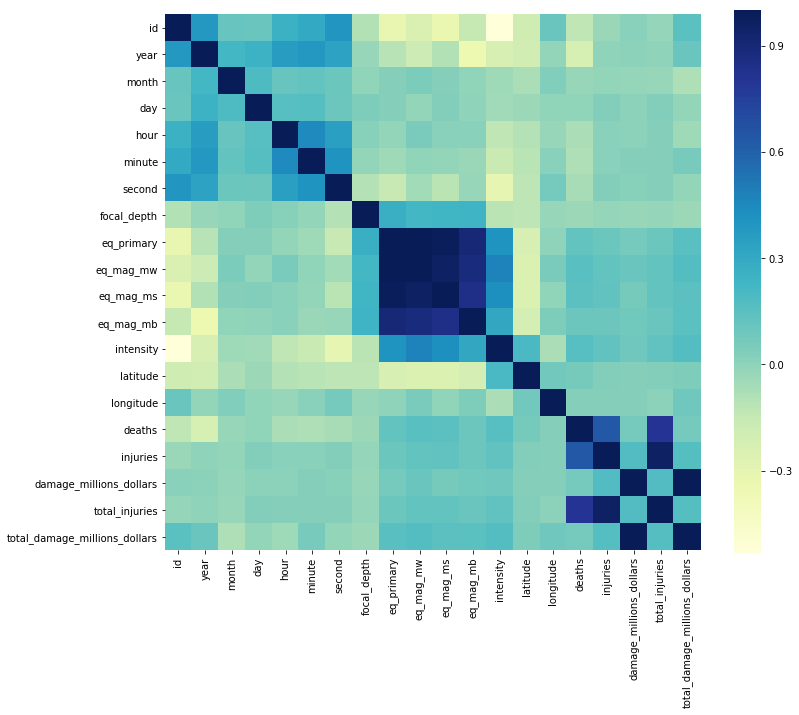

In [28]:
plt.figure(figsize = (12,10))
sns.heatmap(data.corr(), square=True, cmap="YlGnBu")
plt.show()

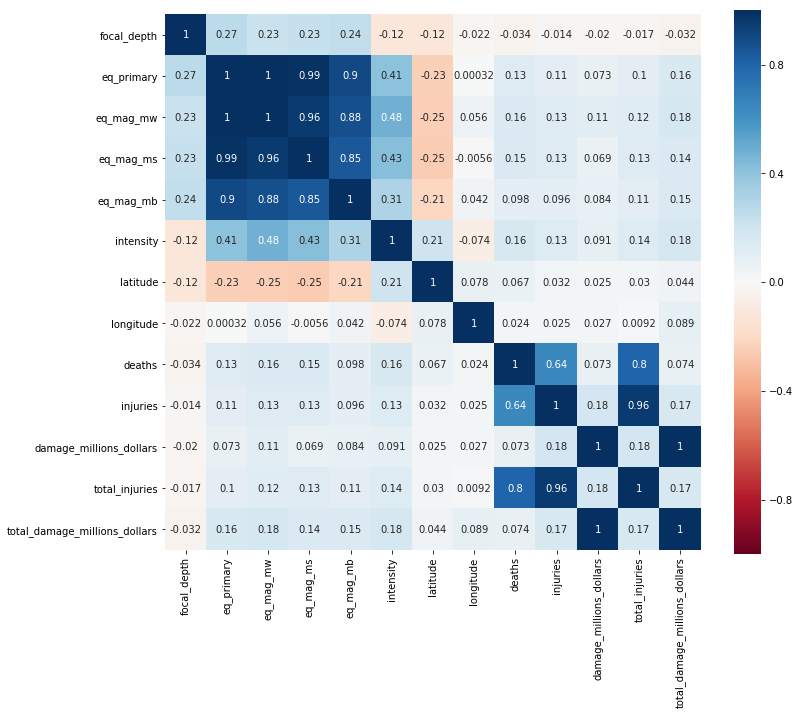

In [29]:
feature_subset = [
    'focal_depth', 'eq_primary', 'eq_mag_mw', 'eq_mag_ms', 'eq_mag_mb', 'intensity',
    'latitude', 'longitude', 'deaths', 'injuries', 'damage_millions_dollars',
    'total_injuries', 'total_damage_millions_dollars']
plt.figure(figsize = (12,10))
sns.heatmap(data[feature_subset].corr(), square=True, annot=True, cmap="RdBu", vmin=-1, vmax=1)
plt.show()

In [30]:
data_to_plot = data[~pd.isnull(data.deaths) & ~pd.isnull(data.eq_primary)]

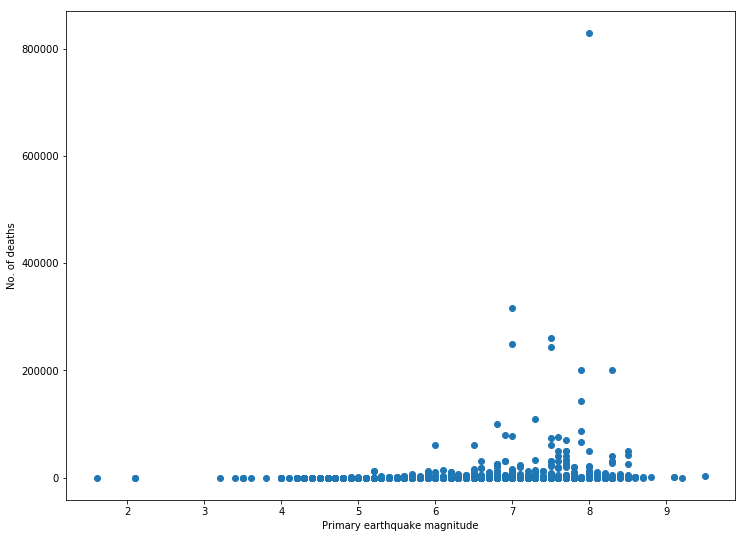

In [31]:
plt.figure(figsize=(12,9))

plt.scatter(x=data_to_plot.eq_primary, y=data_to_plot.deaths)

plt.xlabel('Primary earthquake magnitude')
plt.ylabel('No. of deaths')
plt.show()

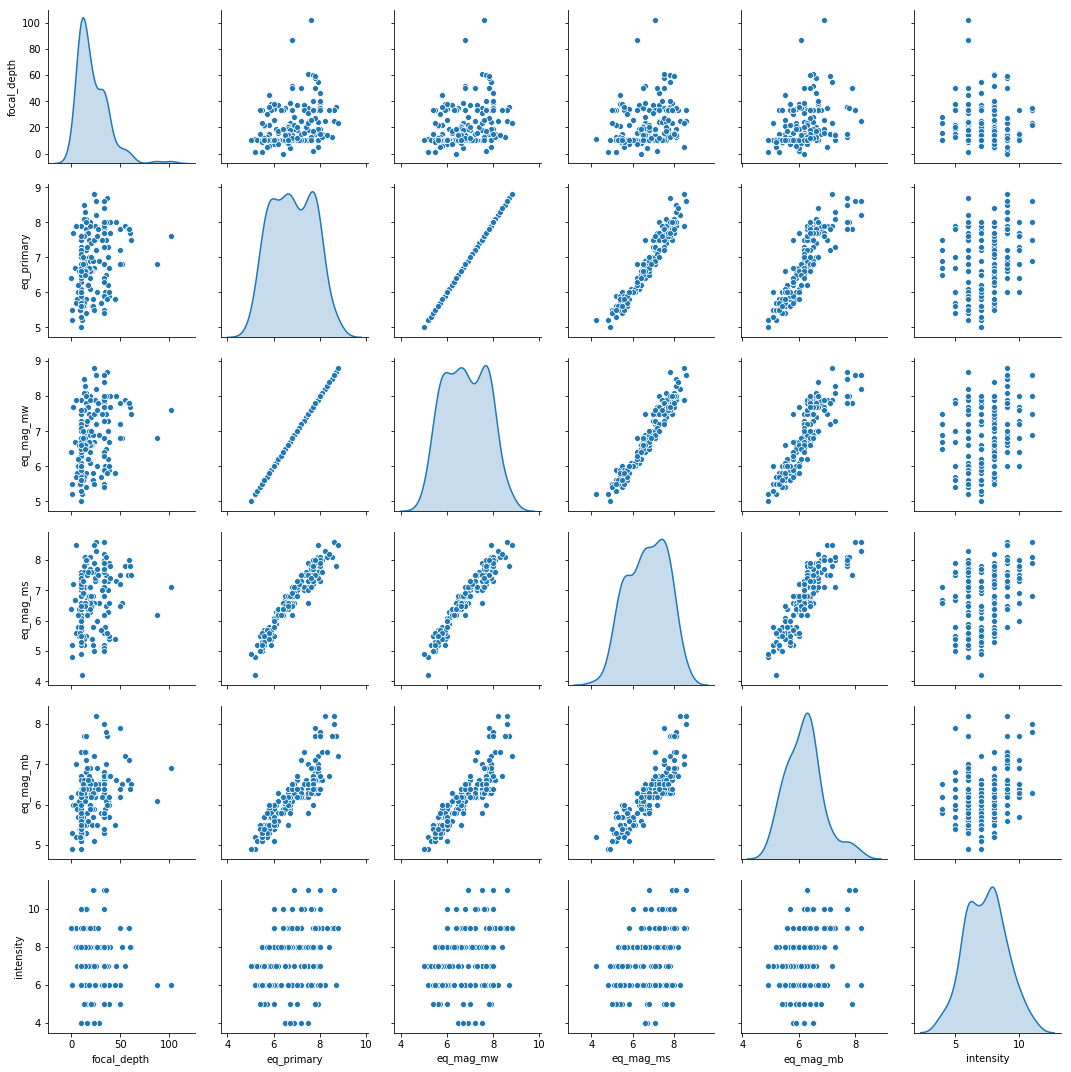

In [32]:
feature_subset = [
    'focal_depth', 'eq_primary', 'eq_mag_mw', 'eq_mag_ms', 'eq_mag_mb', 'intensity',
]
sns.pairplot(data[feature_subset].dropna(), kind ='scatter', diag_kind='kde')
plt.show()

## Between continuous and categorical variables

In [33]:
data.loc[:,'flag_tsunami'] = data.flag_tsunami.apply(lambda t: int(str(t) == 'Tsu'))
data_to_plot = data[~pd.isnull(data.intensity)][['intensity','flag_tsunami']]\
                   .groupby('intensity').sum()
data_to_plot

,flag_tsunami
intensity,
2.0,0
3.0,8
4.0,19
5.0,38
6.0,63
7.0,91
8.0,119
9.0,132
10.0,130


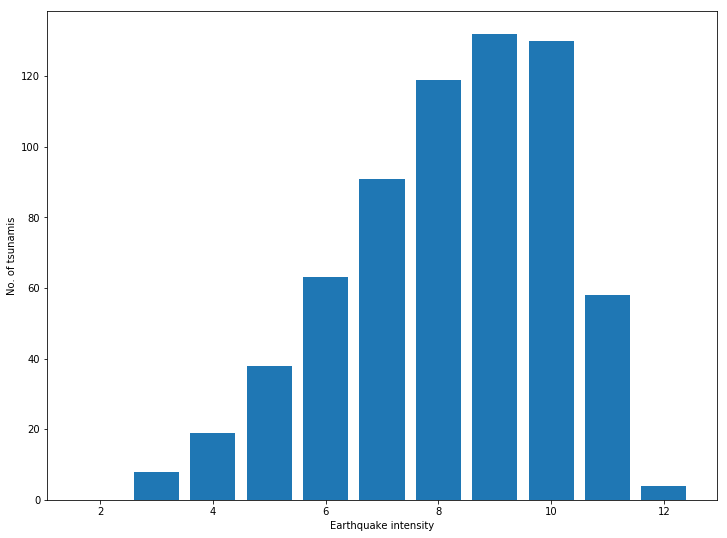

In [34]:
plt.figure(figsize=(12,9))
plt.bar(x=data_to_plot.index, height=data_to_plot.flag_tsunami)
plt.xlabel('Earthquake intensity')
plt.ylabel('No. of tsunamis')
plt.show()

In [35]:
top_countries = data.country.value_counts().index[:13]
subset = data[data.country.isin(top_countries)]

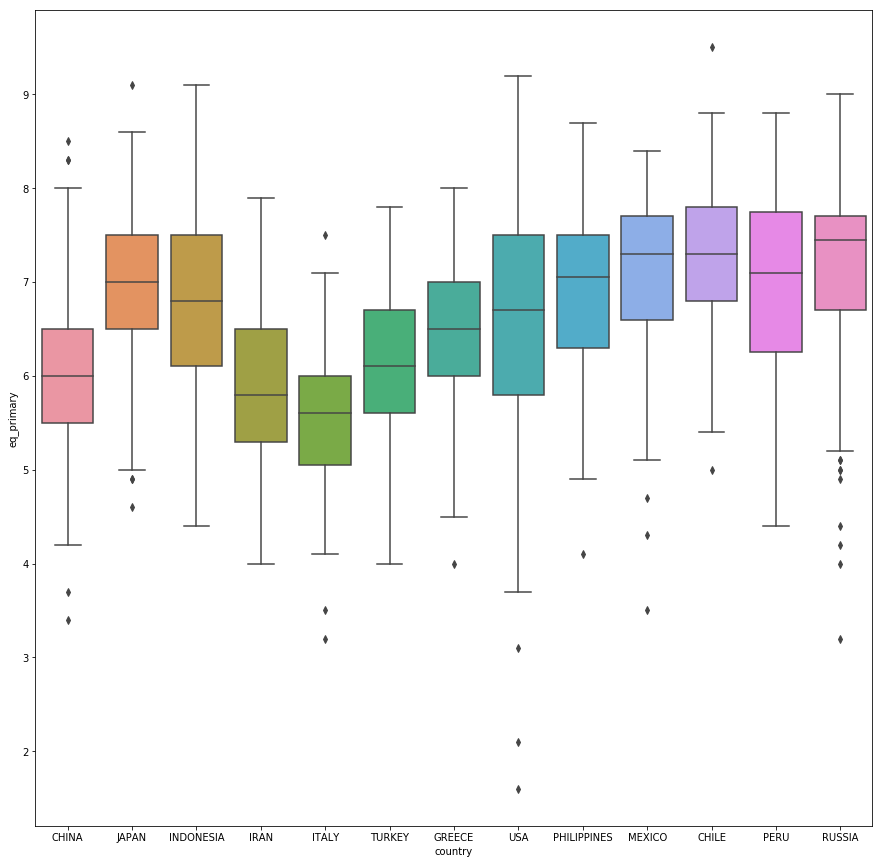

In [36]:
plt.figure(figsize=(15, 15))
sns.boxplot(x='country', y="eq_primary", data=subset, order=top_countries)
plt.show()

## Between categorical variables

In [37]:
data_to_plot = data.groupby(['intensity', 'flag_tsunami']).size().unstack()
data_to_plot

flag_tsunami,0,1
intensity,,
2.0,5.0,NaN
3.0,10.0,8.0
4.0,37.0,19.0
5.0,74.0,38.0
6.0,151.0,63.0
7.0,342.0,91.0
8.0,470.0,119.0
9.0,356.0,132.0
10.0,494.0,130.0


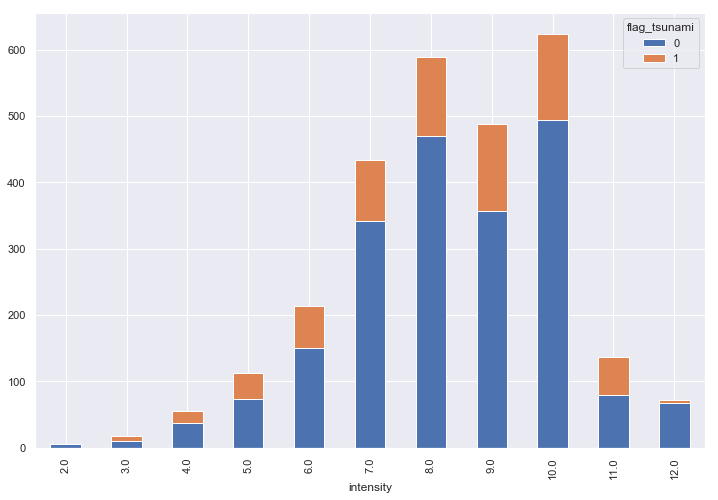

In [38]:
sns.set()
data_to_plot.plot(kind='bar', stacked=True, figsize=(12,8))
plt.show()